In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import optuna

sns.set_theme()

c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
aapl = yf.download('AAPL', start = '2020-01-01', end = '2025-05-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

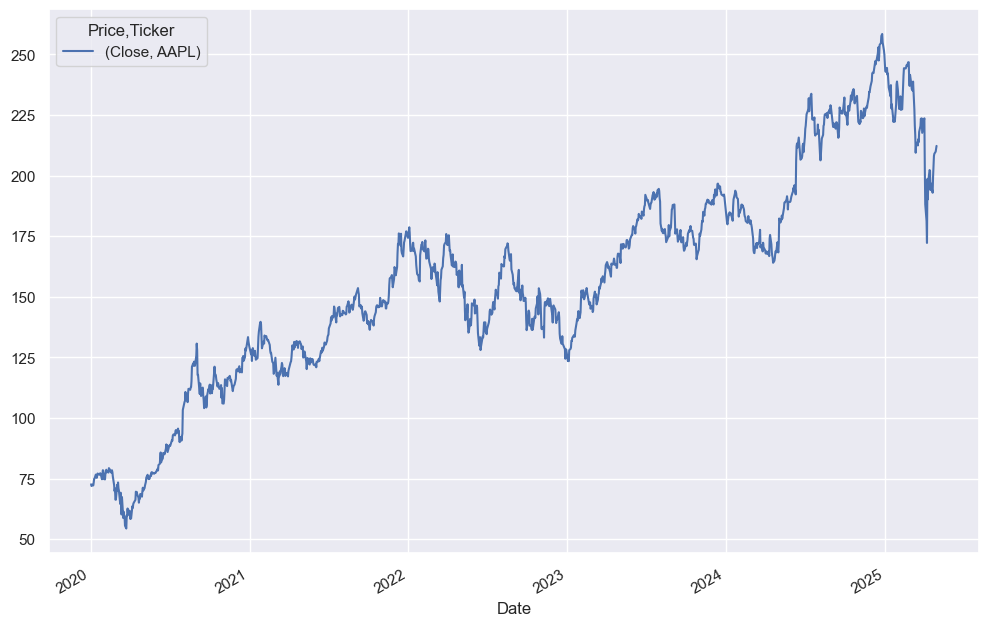

In [3]:
close_values = aapl[['Close']]
close_values.plot(kind = "line", figsize=(12,8))

In [4]:
X_train, X_test = train_test_split(close_values, shuffle = False, test_size = 0.15)

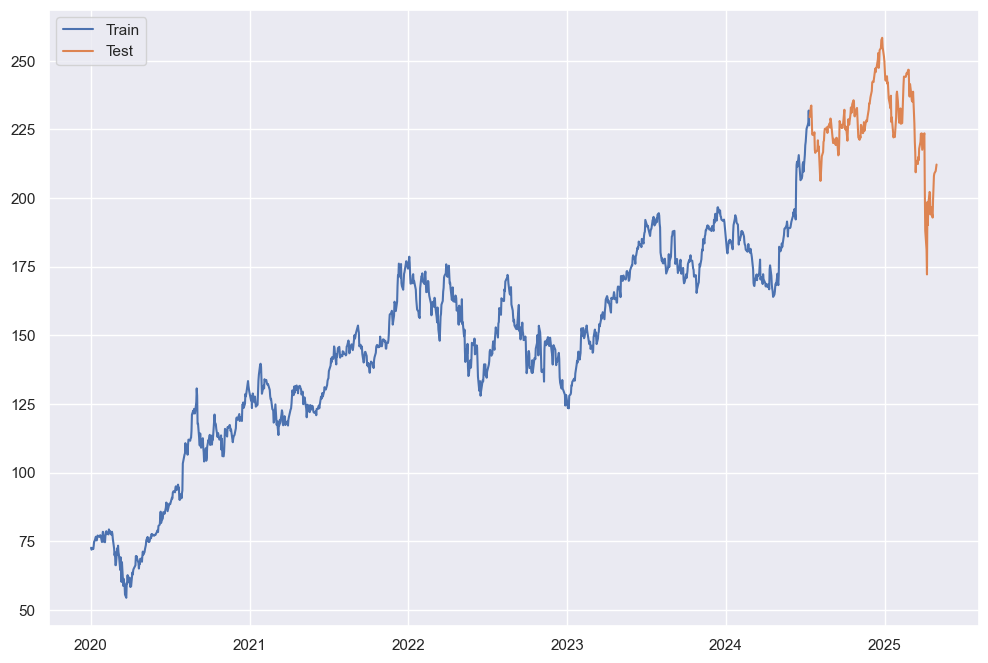

In [5]:
plt.figure(figsize = (12, 8))
plt.plot(X_train.index, X_train.values, label = 'Train')
plt.plot(X_test.index, X_test.values, label = 'Test')
plt.legend()
plt.show()

In [6]:
def prepare_to_training(data):
    for lag in [1, 2, 3]:
        data[f'lag_{lag}'] = data['Close'].shift(lag)
        data[f'dif_{lag}'] = data['Close'].diff(lag)
    data.dropna(inplace = True)

    X = data.drop('Close', axis = 1)
    y = data[['Close']]

    return X, y

In [7]:
X, y = prepare_to_training(X_train)

In [8]:
tscv = TimeSeriesSplit(n_splits=10)
svr  = SVR(kernel = 'rbf')

In [9]:
X_vec, y_vec = X.values, y.values.reshape(-1)

def objective(trial):
    C       = trial.suggest_float('C', 1e-2, 1e2)
    gamma   = trial.suggest_categorical('gamma', ["scale", "auto", 0.01, 0.1, 1])
    epsilon = trial.suggest_float('epsilon', 1e-3, 1e0)

    mses = []
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X_vec[train_idx], X_vec[val_idx]
        y_tr, y_val = y_vec[train_idx], y_vec[val_idx]

        model = SVR(kernel  = 'rbf',
                    C       = C,
                    gamma   = gamma,
                    epsilon = epsilon,
                    shrinking = True)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(y_val, y_pred))

    return np.mean(mses)

In [10]:
# 4. Lanzamos el estudio
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)

# 5. Resultados
print("Mejores hiperparámetros:")
for key, val in study.best_params.items():
    print(f"  - {key}: {val}")
print(f"Mejor MSE en CV: {study.best_value:.4f}")

[I 2025-05-17 15:13:49,181] A new study created in memory with name: no-name-a0baa27d-48d7-41e4-8c64-13d90d57b2d2
[I 2025-05-17 15:13:49,249] Trial 0 finished with value: 47.70923608749166 and parameters: {'C': 11.12812677028758, 'gamma': 'scale', 'epsilon': 0.2778970972556973}. Best is trial 0 with value: 47.70923608749166.
[I 2025-05-17 15:13:49,555] Trial 1 finished with value: 712.1301032139821 and parameters: {'C': 69.97837034195643, 'gamma': 0.01, 'epsilon': 0.2384710947525468}. Best is trial 0 with value: 47.70923608749166.
[I 2025-05-17 15:13:50,216] Trial 2 finished with value: 703.753167698781 and parameters: {'C': 26.901546892060175, 'gamma': 0.01, 'epsilon': 0.03826608018188803}. Best is trial 0 with value: 47.70923608749166.
[I 2025-05-17 15:13:50,337] Trial 3 finished with value: 1125.4837248508288 and parameters: {'C': 6.930623145095523, 'gamma': 0.1, 'epsilon': 0.6614544697605795}. Best is trial 0 with value: 47.70923608749166.
[I 2025-05-17 15:13:50,521] Trial 4 finish

Mejores hiperparámetros:
  - C: 88.07448794084442
  - gamma: scale
  - epsilon: 0.012036022018070816
Mejor MSE en CV: 29.8122


In [11]:
best_params = study.best_params
best_svr = SVR(kernel="rbf", **best_params)
best_svr.fit(X, y)

c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=88.07448794084442, epsilon=0.012036022018070816)

In [12]:
y_predicted = best_svr.predict(X)

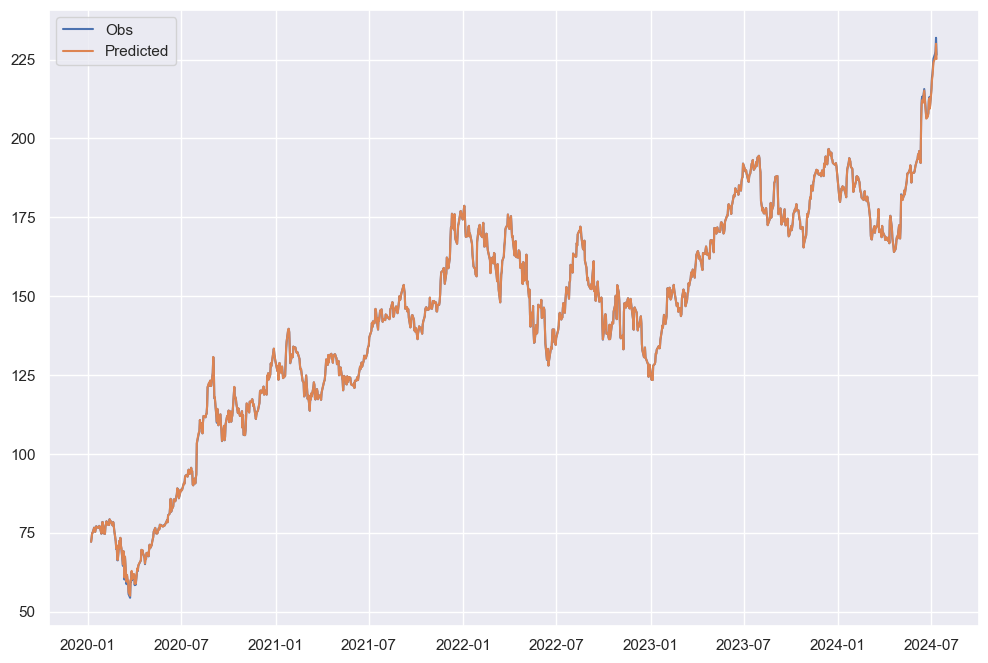

In [13]:
plt.figure(figsize = (12, 8))
plt.plot(y.index, y.values, label = 'Obs')
plt.plot(y.index, y_predicted, label = 'Predicted')
plt.legend()

In [14]:
W, z = prepare_to_training(close_values)

C:\Users\dfdop\AppData\Local\Temp\ipykernel_16792\2849346222.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'lag_{lag}'] = data['Close'].shift(lag)
C:\Users\dfdop\AppData\Local\Temp\ipykernel_16792\2849346222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'dif_{lag}'] = data['Close'].diff(lag)
C:\Users\dfdop\AppData\Local\Temp\ipykernel_16792\2849346222.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [15]:
W_test = W.loc[X_test.index]
z_test = z.loc[X_test.index]

In [16]:
z_pred = best_svr.predict(W_test)

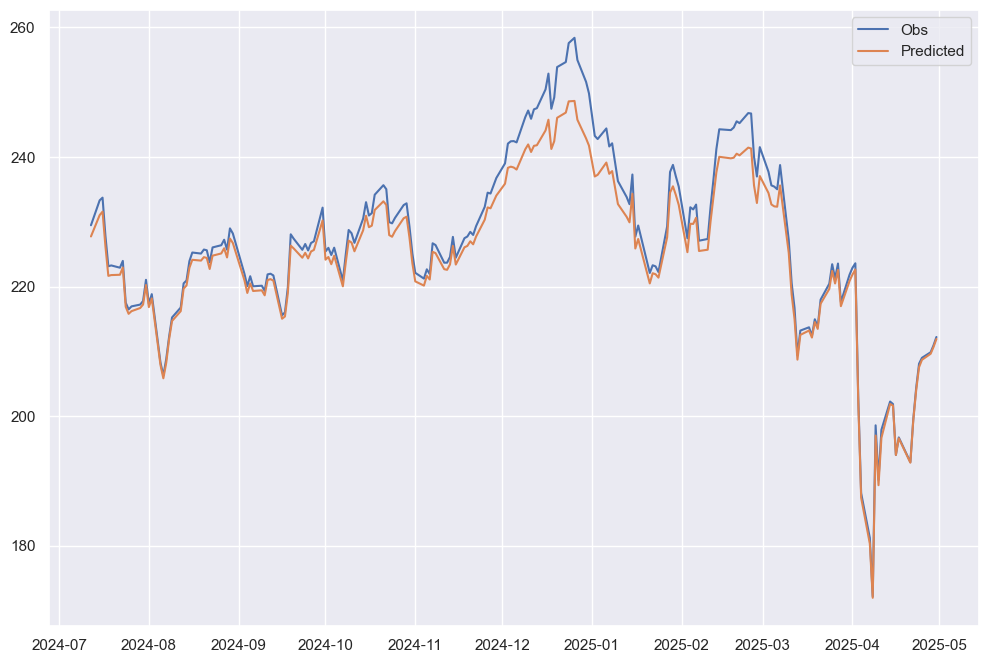

In [17]:
plt.figure(figsize= (12, 8))
plt.plot(X_test.index, z_test, label = "Obs")
plt.plot(X_test.index, z_pred, label = "Predicted")
plt.legend()